In [12]:
using ITensors
ITensors.disable_warn_order()
println(ITensors.blas_get_num_threads())
using ITensorTDVP

8


┌ Info: Precompiling ITensorTDVP [25707e16-a4db-4a07-99d9-4d67b7af0342]
└ @ Base loading.jl:1662


In [2]:
using Revise
using PyPlot
using LaTeXStrings
using PyCall

using LinearAlgebra
using SparseIR
using MultiScales

newaxis = [CartesianIndex()]

rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 18
rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.serif"] = ["Computer Modern Roman"]

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1662
┌ Info: Precompiling MultiScales [d24ad848-1d7e-4ebf-9da3-2ede15b5f46e]
└ @ Base loading.jl:1662


1-element Vector{String}:
 "Computer Modern Roman"

In [3]:
BLAS.set_num_threads(8)

In [206]:
nbits = 6
beta = 10.0
sites = [Index(2, "Qubit, n=$k") for k in 1:nbits]

_reconst(x) = vec(Array(reduce(*, x), reverse(sites)))

_reconst (generic function with 1 method)

In [222]:
v = FermionicFreq(1)
iv = SparseIR.valueim(v, beta)
@show v, iv
ivmps = iv * MultiScales.onemps(ComplexF64, sites)
#_reconst(ivmps)

(v, iv) = (π/β, 0.0 + 0.3141592653589793im)


MPS
[1] ((dim=2|id=855|"Qubit,n=1"), (dim=1|id=130|"Link,l=1"))
[2] ((dim=1|id=130|"Link,l=1"), (dim=2|id=688|"Qubit,n=2"), (dim=1|id=370|"Link,l=2"))
[3] ((dim=1|id=370|"Link,l=2"), (dim=2|id=136|"Qubit,n=3"), (dim=1|id=116|"Link,l=3"))
[4] ((dim=1|id=116|"Link,l=3"), (dim=2|id=286|"Qubit,n=4"), (dim=1|id=252|"Link,l=4"))
[5] ((dim=1|id=252|"Link,l=4"), (dim=2|id=218|"Qubit,n=5"), (dim=1|id=922|"Link,l=5"))
[6] ((dim=1|id=922|"Link,l=5"), (dim=2|id=553|"Qubit,n=6"))


In [208]:
function _setbit(sites, pos)
    1 <= pos <= length(sites) || error("Invalid pos")
    states = repeat(["0"], length(sites))
    states[pos] = "1"
    @show states
    return MPS(sites, states)
end

#hr = _setbit(sites, nbits)
hr = _setbit(sites, 1) + MPS(sites, repeat(["1"], length(sites)))
#hr = MPS(sites, repeat(["1"], length(sites)))
#_reconst(hr)

states = ["1", "0", "0", "0", "0", "0"]


MPS
[1] ((dim=2|id=855|"Qubit,n=1"), (dim=2|id=578|"Link,l=1"))
[2] ((dim=2|id=688|"Qubit,n=2"), (dim=2|id=459|"Link,l=2"), (dim=2|id=578|"Link,l=1"))
[3] ((dim=2|id=136|"Qubit,n=3"), (dim=2|id=308|"Link,l=3"), (dim=2|id=459|"Link,l=2"))
[4] ((dim=2|id=286|"Qubit,n=4"), (dim=2|id=885|"Link,l=4"), (dim=2|id=308|"Link,l=3"))
[5] ((dim=2|id=218|"Qubit,n=5"), (dim=2|id=9|"Link,l=5"), (dim=2|id=885|"Link,l=4"))
[6] ((dim=2|id=553|"Qubit,n=6"), (dim=2|id=9|"Link,l=5"))


In [209]:
ftcore = MultiScales.FTCore(sites; cutoff=1e-20)
Mft = (2.0^(0.5*length(sites))) * MultiScales.backwardmpo(ftcore, sites; inputorder=:reversed)

MPO
[1] ((dim=2|id=855|"Qubit,n=1")', (dim=2|id=855|"Qubit,n=1"), (dim=2|id=983|"Link,n=1"))
[2] ((dim=2|id=688|"Qubit,n=2")', (dim=2|id=688|"Qubit,n=2"), (dim=4|id=864|"Link,n=2"), (dim=2|id=983|"Link,n=1"))
[3] ((dim=2|id=136|"Qubit,n=3")', (dim=2|id=136|"Qubit,n=3"), (dim=8|id=787|"Link,n=3"), (dim=4|id=864|"Link,n=2"))
[4] ((dim=2|id=286|"Qubit,n=4")', (dim=2|id=286|"Qubit,n=4"), (dim=4|id=3|"Link,n=4"), (dim=8|id=787|"Link,n=3"))
[5] ((dim=2|id=218|"Qubit,n=5")', (dim=2|id=218|"Qubit,n=5"), (dim=2|id=795|"Link,n=5"), (dim=4|id=3|"Link,n=4"))
[6] ((dim=2|id=553|"Qubit,n=6")', (dim=2|id=553|"Qubit,n=6"), (dim=2|id=795|"Link,n=5"))


In [210]:
hk = apply(Mft, hr; cutoff=1e-20)
@assert _reconst(hk)[1] ≈ 2.0

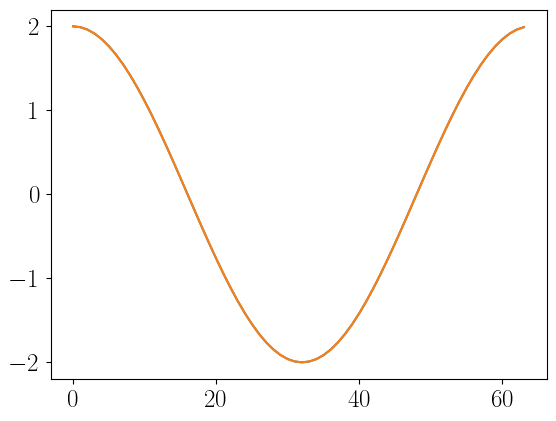

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x151dba689340>

In [211]:
kmesh = LinRange(0, 2π, 2^nbits+1)[1:end-1]
hk_ref = 2*cos.(kmesh)
plot(real.(_reconst(hk)))
plot(real.(hk_ref))

In [212]:
amps = ivmps - hk
#_reconst(amps)

MPS
[1] ((dim=2|id=855|"Qubit,n=1"), (dim=2|id=581|"Link,l=1"))
[2] ((dim=2|id=688|"Qubit,n=2"), (dim=3|id=165|"Link,l=2"), (dim=2|id=581|"Link,l=1"))
[3] ((dim=2|id=136|"Qubit,n=3"), (dim=3|id=156|"Link,l=3"), (dim=3|id=165|"Link,l=2"))
[4] ((dim=2|id=286|"Qubit,n=4"), (dim=3|id=198|"Link,l=4"), (dim=3|id=156|"Link,l=3"))
[5] ((dim=2|id=218|"Qubit,n=5"), (dim=2|id=824|"Link,l=5"), (dim=3|id=198|"Link,l=4"))
[6] ((dim=2|id=553|"Qubit,n=6"), (dim=2|id=824|"Link,l=5"))


In [224]:
b = MultiScales.onemps(ComplexF64, sites)
#A0 = MultiScales.tompo_elementwiseprod(ivmps)
#A = MultiScales.tompo_elementwiseprod(amps)
x0 = b

cutoff = 1E-25
maxdim = 100
nsweeps = 2

for coeff in [0.0, 0.2, 0.4, 1.0]
    A = MultiScales.tompo_elementwiseprod(ivmps - coeff * hk)
    x = linsolve(A, b, x0; cutoff, maxdim, nsweeps, solver_maxiter=1000, solver_krylovdim=30)
    #@show maximum(abs, _reconst(apply(A, x)) .- ones(2^nbits))
    @show _reconst(apply(A, x))[1:5]
    x0 = copy(x)
end
#@show _reconst(b)
#
#gmps = x0
#g0mps = linsolve(A0, b, x0; cutoff, maxdim, nsweeps)
#gmps = linsolve(A, b, g0mps; cutoff, maxdim, nsweeps, solver_maxiter=1000)

(_reconst(apply(A, x)))[1:5] = ComplexF64[1.0000000000000007 + 7.588908775888116e-32im, 0.9999999999999998 + 6.972611193684194e-32im, 1.0000000000000013 + 7.588908775888116e-32im, 1.0000000000000002 + 6.972611193684194e-32im, 1.0000000000000007 + 6.1629758220391534e-33im]
(_reconst(apply(A, x)))[1:5] = ComplexF64[-0.9987952365664756 - 0.049072144972216666im, -0.9987952365657651 - 0.049072144989993315im, -0.9987952365676644 - 0.0490721449462641im, -0.9987952365630215 - 0.049072145036227116im, -0.9987952365673621 - 0.04907214495686901im]
(_reconst(apply(A, x)))[1:5] = ComplexF64[-0.9983121124933728 - 0.05807689818555337im, -0.9983121115254066 - 0.05807691467278134im, -0.9983121125693772 - 0.058076895931155344im, -0.9983121112173282 - 0.058076920923880226im, -0.9983121122127051 - 0.05807690339923075im]
(_reconst(apply(A, x)))[1:5] = ComplexF64[-0.9982325791176982 - 0.05942895325198308im, -0.9982323921890415 - 0.05943048897919356im, -0.9982324536878036 - 0.059429735944843694im, -0.99823243

In [169]:
_reconst(apply(A, gmps))

1024-element Vector{ComplexF64}:
  -0.519820617417338 + 0.5994345096635068im
 -0.7686711157156767 + 0.7064950517022887im
 -0.9828022298796719 + 0.7984423522474002im
 -1.1621097891942915 + 0.8713198965800579im
  -1.304823996914343 + 0.9196457891534627im
 -1.4241710240364704 + 0.9554706562385378im
 -1.5118109052651443 + 0.9665560926701664im
  -1.568148599208175 + 0.9521668843194409im
 -1.6234776475641604 + 0.9269014145300287im
 -1.6901701139294554 + 0.9127458850849912im
 -1.7292702127447586 + 0.8772553204960838im
 -1.7478152450377842 + 0.8290921654808155im
 -1.7483867017565864 + 0.7732153348654791im
                     ⋮
  -1.699102636671137 + 0.8779574827973844im
 -1.6812844465077106 + 0.9423613217850484im
  -1.642296801598192 + 0.9912686856655748im
 -1.5793570794383962 + 1.0180213764371728im
 -1.5213637628744436 + 1.0339383753715252im
  -1.471149609179536 + 1.0578873746925495im
 -1.3906762081627468 + 1.0497328223139772im
 -1.2836619011440642 + 1.013021611404415im
 -1.1488457286415237 

In [141]:
#_reconst(x)
#gref

In [146]:
gref = 1 ./ (_reconst(ivmps) .- _reconst(hk))
greconst = _reconst(gmps)
;

xvec = _reconst(x) .* _reconst()

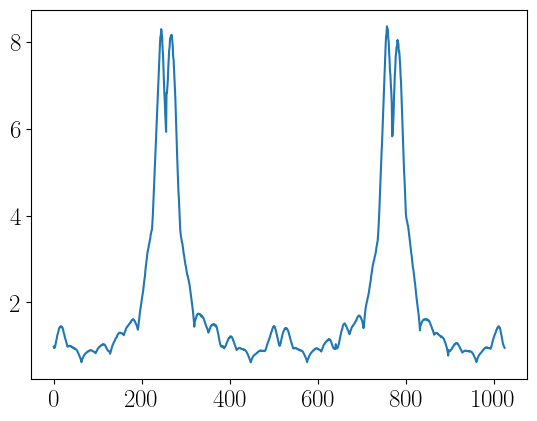

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x151dba90e880>

In [147]:
plot(abs.(gref .- greconst))